<a href="https://colab.research.google.com/github/kumar-abhishek/handson-ml2/blob/master/Chris_BachChorales_HandsOnCh15_2020_01_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow is already loaded. Please restart the runtime to change versions.


AssertionError: ignored

> Ch15 Q10 
>
> Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale."

The Bach chorales are available from:

https://github.com/ageron/handson-ml2/blob/master/datasets/jsb_chorales/jsb_chorales.tgz

I downloaded them to my Google Drive. Then I mounted my Google Drive to Google Colab:

`Expand the left pane > Files > Mount Drive`

In [7]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
def read_dir_of_chorales(dir):

  print("\nReading chorales in: " + dir + "\n---------------\n")

  chorales = []
  file_counter = 0
  for filename in sorted(os.listdir(dir)):
    file_counter += 1
    if (file_counter % 10) == 0:
      print(str(file_counter) + ") filename: " + filename)

    one_training_chorale = pd.read_csv(os.path.join(dir, filename)).to_numpy()
    chorales.append(one_training_chorale)

  return chorales

In [10]:
data_path = "/content/drive/My Drive/jsb_chorales"

train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test')

bach_training_chorales = read_dir_of_chorales(train_path)
bach_validation_chorales = read_dir_of_chorales(valid_path)
bach_test_chorales = read_dir_of_chorales(test_path)

# bach_training_chorales = []
# file_counter = 0
# for filename in sorted(os.listdir(train_path)):
#   file_counter += 1
#   if (file_counter % 10) == 0:
#     print(str(file_counter) + ") filename: " + filename)
#   one_training_chorale = pd.read_csv(os.path.join(train_path, filename)).to_numpy()
#   bach_training_chorales.append(one_training_chorale)



Reading chorales in: /content/drive/My Drive/jsb_chorales/train
---------------

10) filename: chorale_009.csv
20) filename: chorale_019.csv
30) filename: chorale_029.csv
40) filename: chorale_039.csv
50) filename: chorale_049.csv
60) filename: chorale_059.csv
70) filename: chorale_069.csv
80) filename: chorale_079.csv
90) filename: chorale_089.csv
100) filename: chorale_099.csv
110) filename: chorale_109.csv
120) filename: chorale_119.csv
130) filename: chorale_129.csv
140) filename: chorale_139.csv
150) filename: chorale_149.csv
160) filename: chorale_159.csv
170) filename: chorale_169.csv
180) filename: chorale_179.csv
190) filename: chorale_189.csv
200) filename: chorale_199.csv
210) filename: chorale_209.csv
220) filename: chorale_219.csv

Reading chorales in: /content/drive/My Drive/jsb_chorales/valid
---------------

10) filename: chorale_238.csv
20) filename: chorale_248.csv
30) filename: chorale_258.csv
40) filename: chorale_268.csv
50) filename: chorale_278.csv
60) filename:

Sanity check for what the data looks like

In [11]:
chorale_counter = 0
for chorale in bach_training_chorales:
  chorale_counter += 1
  if chorale_counter > 3: break

  print("Chorale #" + str(chorale_counter))
  print("Shape: " + str(chorale.shape))
  print(chorale[:6])
  print(" ...\n")


Chorale #1
Shape: (192, 4)
[[74 70 65 58]
 [74 70 65 58]
 [74 70 65 58]
 [74 70 65 58]
 [75 70 58 55]
 [75 70 58 55]]
 ...

Chorale #2
Shape: (228, 4)
[[69 64 61 57]
 [69 64 61 57]
 [69 64 61 57]
 [69 64 61 57]
 [71 64 59 56]
 [71 64 59 56]]
 ...

Chorale #3
Shape: (208, 4)
[[67 62 59 55]
 [67 62 59 55]
 [67 62 59 55]
 [67 62 59 55]
 [67 64 60 48]
 [67 64 60 48]]
 ...



> Ch 15 Q 10
>
> Train a model--recurrent, convolutional, or both--that can predict the next time step (four notes), given a sequence of time steps from a chorale.

### Approaches

Hmmm, three approaches seem reasonable to this problem:

1) We could treat this as a regression problem where we try to predict the next note value along the real line. In this case, Mean Squared Error (MSE) seems like the most reasonable metric to use. (Note that MSE is the cross-entropy when we assume that there is gaussian noise added to each output value.)

2) But in "music space" neighboring notes can actually be further apart than notes from the same chord or key, it may make more sense to treat each note as a separate class and measure performance as the cross-entropy of the "multi-noulli" distribution. 

3) We could design a custom loss that accounts for our knowledge of music theory. A loss that directly accounts for deviations from the chord or key.

A custom loss would take a lot of time to implement. Plus, our model may well learn most of the music theory simply by observing the note combinations in the chorales. So let's rule out option 3.

Since the notes are represented as numbers, regression looks like the obvious choice, but with my knowledge of music I am inclined toward option 2. I will start with option 2 and revisit option 1 if I have time.

### The multiple outputs

Another wrinkle in this task is that there are 4 outputs (4 notes) at each time step. With enough training data, we might be able to treat each separate combination of 4 notes as a separate class, but for this exercise my loss will just be the sum of the losses across the 4 notes. 

(Another idea would be to train a GAN style loss function that rates each 4 note combination on it's likelihood. We could create training data of random combinations of notes and train a classifier to distinguish them from real note combinations. But again, too complicated for this first stab.)

First, let's gather some baseline metrics

### Multinouli MLE Loss

So, our first model will be a classifier with average MLE (aka cross-entropy) loss across the 4 notes.

But FIRST, I need to build a model with **1** input and **1** output for the sake of sanity.

In [12]:
def split_off_bass(chorales):

  bach_chorales_minus_last_notes = []
  last_notes = []
  next_to_last_notes = []
  bach_chorales_bass_last_notes = []
  bass_next_to_last = []
  for chorale in chorales:
    bach_chorales_minus_last_notes.append(chorale[:-1])
    if len(chorale)>0: 
      last_notes.append(chorale[-1])
    if len(next_to_last_notes)>1:
      next_to_last_notes.append(chorale[-2])
    if len(chorale)>0:
      bach_chorales_bass_last_notes.append([chorale[-1]])
    if len(chorale)>1:
      bass_next_to_last.append([chorale[-2, 0]])

  return bach_chorales_minus_last_notes, np.array(last_notes), np.array(next_to_last_notes), np.array(bach_chorales_bass_last_notes), np.array(bass_next_to_last)


training_minus_last_notes, training_last_notes, training_next_to_last_notes, bach_training_chorales_bass_last_notes, training_bass_next_to_last = split_off_bass(bach_training_chorales)

validation_minus_last_notes, validation_last_notes, validation_next_to_last_notes, bach_validation_chorales_bass_last_notes, validation_bass_next_to_last = split_off_bass(bach_validation_chorales)

test_minus_last_notes, test_last_notes, test_next_to_last_notes, bach_test_chorales_bass_last_notes, test_bass_next_to_last = split_off_bass(bach_test_chorales)

print("len(bach_training_choraels[0]): ", len(bach_training_chorales[0]))
print("len(training_minus_last_notes[0]): ", len(training_minus_last_notes[0]))
print("bach_training_chorales[0][-1]: ", bach_training_chorales[0][-1])
print("training_minus_last_notes[0][-1]: ", training_minus_last_notes[0][-1])

print("training_last_notes.shape: ", training_last_notes.shape)
print("training_last_notes[0]: ", training_last_notes[0])
print("bach_training_chorales_bass_last_notes.shape: ", bach_training_chorales_bass_last_notes.shape)
print("bach_training_chorales_bass_last_notes[0]: ", bach_training_chorales_bass_last_notes[0])


len(bach_training_choraels[0]):  192
len(training_minus_last_notes[0]):  191
bach_training_chorales[0][-1]:  [70 65 62 46]
training_minus_last_notes[0][-1]:  [70 65 62 46]
training_last_notes.shape:  (229, 4)
training_last_notes[0]:  [70 65 62 46]
bach_training_chorales_bass_last_notes.shape:  (229, 1, 4)
bach_training_chorales_bass_last_notes[0]:  [[70 65 62 46]]


Here's a simple baseline: Predict the next-to-last bass note -- the last note in the validation set is **always** exactly equal to the last note.

In [15]:
np.mean(keras.losses.mean_squared_error(bach_validation_chorales_bass_last_notes, validation_bass_next_to_last))

NotImplementedError: ignored

Still, just to figure out **how** to train a network at all, I'll build an RNN to predict the final bass note.

In [0]:
bach_training_chorales_padded = tf.keras.preprocessing.sequence.pad_sequences(bach_training_chorales, padding='post', maxlen=576)
bach_validation_chorales_padded =  tf.keras.preprocessing.sequence.pad_sequences(bach_validation_chorales, padding='post', maxlen=576)
training_minus_last_notes_padded = tf.keras.preprocessing.sequence.pad_sequences(training_minus_last_notes, padding='post', maxlen=576)
validation_minus_last_notes_padded =  tf.keras.preprocessing.sequence.pad_sequences(validation_minus_last_notes, padding='post', maxlen=576)

In [17]:
bach_training_chorales_padded.shape, bach_training_chorales_bass_last_notes.shape, training_minus_last_notes_padded.shape

((229, 576, 4), (229, 1, 4), (229, 576, 4))

In [18]:
bach_validation_chorales_padded.shape, bach_validation_chorales_bass_last_notes.shape, validation_minus_last_notes_padded.shape

((76, 576, 4), (76, 1, 4), (76, 576, 4))

In [24]:
print(training_minus_last_notes_padded[0:2])

[[[74 70 65 58]
  [74 70 65 58]
  [74 70 65 58]
  ...
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[69 64 61 57]
  [69 64 61 57]
  [69 64 61 57]
  ...
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]]


In [28]:
print(bach_training_chorales_bass_last_notes[0:2])
# Kumar fix: This is wrong. Need to shift the whole input by one and then use that as y. So y will look pretty much like x.

[[[70 65 62 46]]

 [[69 61 52 45]]]


In [23]:
#from keras.models import Sequential
from keras import optimizers
#from keras.layers import LSTM
#from keras.layers import Dense, Dropout, BatchNormalization, TimeDistributed
# the dataset knows the number of features, e.g. 2
n_features = 4

# choose a number of time steps
n_steps = None

model = keras.models.Sequential()

#model.add(keras.layers.TimeDistributed(keras.layers.Dense(128), input_shape=(None, n_features)) ) # This line makes a lot of difference but why?

model.add(keras.layers.LSTM(64, input_shape=(None, n_features), return_sequences=True))
#model.add(BatchNormalization())
#model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.LSTM(32))
#model.add(BatchNormalization())
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(4))
model.compile(optimizer='adam', loss='mse')

# fit model
#model.fit(training_minus_last_notes_padded, bach_training_chorales_bass_last_notes, epochs=200, validation_data=(validX, validY))
model.fit(training_minus_last_notes_padded, bach_training_chorales_bass_last_notes, epochs=200)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 229 samples
Epoch 1/200
229/229 [==============================] - 16s 72ms/sample - loss: 3415.3428
Epoch 2/200
229/229 [==============================] - 6s 28ms/sample - loss: 3382.9871
Epoch 3/200
229/229 [==============================] - 6s 27ms/sample - loss: 3272.2473
Epoch 4/200
229/229 [==============================] - 6s 28ms/sample - loss: 3153.8106
Epoch 5/200
229/229 [==============================] - 6s 28ms/sample - loss: 3064.7359
Epoch 6/200
229/229 [==============================] - 6s 28ms/sample - loss: 2963.8296
Epoch 7/200
229/229 [==============================] - 6s 28ms/sample - loss: 2883.1676
Epoch 8/200
229/229 [==============================] - 6s 28ms/sample - loss: 2811.4219
Epoch 9/200
229/229 [==============================] - 6s 28ms/sample - loss: 2745.6492
Epoch 10/200
229/229 [==============================] - 6s 28ms/sample - loss: 2678.4965
Epo

KeyboardInterrupt: ignored

In [27]:
# demonstrate prediction
#x_input = dataXScaler[2:30]
x_input = training_minus_last_notes_padded[0][2:30]
x_input = x_input.reshape((1, len(x_input), 4))
#print(scaler.inverse_transform(dataXScaler)[2:30])
print(x_input)
yhat = model.predict(x_input, verbose=0)
#print(scaler.inverse_transform(yhat))
print(yhat)
print('expected: ', bach_training_chorales_bass_last_notes[31])

[[[74 70 65 58]
  [74 70 65 58]
  [75 70 58 55]
  [75 70 58 55]
  [75 70 60 55]
  [75 70 60 55]
  [77 69 62 50]
  [77 69 62 50]
  [77 69 62 50]
  [77 69 62 50]
  [77 70 62 55]
  [77 70 62 55]
  [77 69 62 55]
  [77 69 62 55]
  [75 67 63 48]
  [75 67 63 48]
  [75 69 63 48]
  [75 69 63 48]
  [74 70 65 46]
  [74 70 65 46]
  [74 70 65 46]
  [74 70 65 46]
  [72 69 65 53]
  [72 69 65 53]
  [72 69 65 53]
  [72 69 65 53]
  [72 69 65 53]
  [72 69 65 53]]]
[[[6.5378504 6.9270573 7.531531  6.393796 ]
  [7.976067  8.63474   9.192688  7.9871573]
  [8.20709   8.911125  9.45411   8.235421 ]
  [8.23908   8.949426  9.490234  8.269689 ]
  [8.243425  8.954627  9.495138  8.274339 ]
  [8.244013  8.955331  9.495802  8.274968 ]
  [8.244092  8.955425  9.495893  8.275054 ]
  [8.244103  8.95544   9.495905  8.275065 ]
  [8.244105  8.9554405 9.495907  8.275067 ]
  [8.244105  8.955441  9.495907  8.275067 ]
  [8.244105  8.955441  9.495907  8.275067 ]
  [8.244105  8.955441  9.495907  8.275067 ]
  [8.244105  8.955441 

In [51]:

#np.random.seed(42)
#tf.random.set_seed(42)

model = keras.models.Sequential([
    #keras.layers.Masking(mask_value=0., input_shape=(576, 4)),
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 4]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(training_minus_last_notes_padded, bach_training_chorales_bass_last_notes, epochs=25,
                     validation_data=(validation_minus_last_notes_padded, bach_validation_chorales_bass_last_notes))
#history = model.fit(training_minus_last_notes_padded, bach_training_chorales_bass_last_notes, epochs=25)

Train on 229 samples, validate on 76 samples
Epoch 1/25


InvalidArgumentError: ignored

Sadly, the RNN can never get below MSE of ~10. Let's look at the weights. 

After googling the weight order, I find the weights go:

1) Input
2) Recurrent (for RNN layer)
3) Bias

Weights are never easy to understand, but consider the 2nd simple RNN bias weights along with the Dense weights. 

A) The signs of the corrosponding bias and dense weights always match.
B) The Dense weights are always ~3.

Since the simple RNN goes through a tanh activation, the output of each of the of the 20 2nd layer RNNs nodes is between 1 and -1. It seems to me, that this model is doing nothing but adding up 20 3's to get into the ball park of the correct note and calling it good enough. :-( 

In [0]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'name': 'masking_5', 'trainable': True, 'batch_input_shape': (None, 576, 4), 'dtype': 'float32', 'mask_value': 0.0} []
{'name': 'simple_rnn_9', 'trainable': True, 'batch_input_shape': (None, None, 4), 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 20, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0} [array([[-1.3571543e-01,  2.4127939e-01,  1.5310624e-01,  1.5859830e-01,
        -1.2377863e-01,  4.7879454e-01,  5.4036427

Again, just for sanity, I want to verify that I **can** build a NN that has 4 outputs. Even if the model isn't very interesting.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Masking(mask_value=0., input_shape=(576, 4)),
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 4]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(4)
])

optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(training_minus_last_notes_padded, training_last_notes, epochs=25,
                    validation_data=(validation_minus_last_notes_padded, validation_last_notes))

Train on 229 samples, validate on 76 samples
Epoch 1/25
229/229 [==============================] - 10s 44ms/sample - loss: 2983.4738 - val_loss: 2520.8986
Epoch 2/25
229/229 [==============================] - 9s 38ms/sample - loss: 2163.7497 - val_loss: 1778.5867
Epoch 3/25
229/229 [==============================] - 9s 38ms/sample - loss: 1490.5650 - val_loss: 1188.9859
Epoch 4/25
229/229 [==============================] - 8s 35ms/sample - loss: 972.0766 - val_loss: 755.3505
Epoch 5/25
229/229 [==============================] - 8s 36ms/sample - loss: 601.8528 - val_loss: 456.7926
Epoch 6/25
229/229 [==============================] - 8s 36ms/sample - loss: 354.0218 - val_loss: 262.4928
Epoch 7/25
229/229 [==============================] - 8s 35ms/sample - loss: 197.5704 - val_loss: 145.5637
Epoch 8/25
229/229 [==============================] - 8s 36ms/sample - loss: 106.6363 - val_loss: 78.9869
Epoch 9/25
229/229 [==============================] - 8s 36ms/sample - loss: 57.0923 - val_lo

In [0]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'name': 'masking_6', 'trainable': True, 'batch_input_shape': (None, 576, 4), 'dtype': 'float32', 'mask_value': 0.0} []
{'name': 'simple_rnn_11', 'trainable': True, 'batch_input_shape': (None, None, 4), 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 20, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0} [array([[-0.13571541,  0.24123825, -0.44739515,  0.25157785, -0.76661646,
        -0.11560518,  0.5401584 ,  0.07216869, -

- Predict final time step on validation set and see what they look like qualitatively

In [0]:
predictions = model.predict(validation_minus_last_notes_padded)
print("Validation Predictions: ", predictions[:10])

print("\nValidation Truth: ", validation_last_notes[:10])

Validation Predictions:  [[67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]
 [67.176765 61.742683 57.491055 45.541584]]

Validation Truth:  [[72 67 64 48]
 [60 55 52 48]
 [69 64 61 45]
 [71 63 54 47]
 [75 67 58 39]
 [72 64 55 48]
 [71 63 54 47]
 [67 62 59 43]
 [74 66 57 50]
 [69 64 61 45]]


As I suspected. The model has learned to ignore the input and just predict an average value, because it is close enough :-(

But, if we play the wrong note, then we are actually completely wrong! Let's figure out a softmax model

In [0]:
training_bass_last_notes_categorical = keras.utils.to_categorical(bach_training_chorales_bass_last_notes, num_classes=100)
validation_bass_last_notes_categorical = keras.utils.to_categorical(bach_validation_chorales_bass_last_notes, num_classes=100)
test_bass_last_notes_categorical = keras.utils.to_categorical(bach_test_chorales_bass_last_notes, num_classes=100)

In [0]:
def get_last_notes(chorales):

  last_notes = []
  last_note1s = []
  last_note2s = []
  last_note3s = []
  last_note4s = []
  for chorale in chorales:
    last_notes.append(chorale[-1])
    last_note1s.append([chorale[-1, 0]])
    last_note2s.append([chorale[-1, 1]])
    last_note3s.append([chorale[-1, 2]])
    last_note4s.append([chorale[-1, 3]])

  return last_notes, last_note1s, last_note2s, last_note3s, last_note4s


training_last_notes, training_last_note1s, training_last_note2s, training_last_note3s, training_last_note4s = get_last_notes(bach_training_chorales)
validation_last_notes, validation_last_note1s, validation_last_note2s, validation_last_note3s, validation_last_note4s = get_last_notes(bach_validation_chorales)
test_last_notes, test_last_note1s, test_last_note2s, test_last_note3s, test_last_note4s = get_last_notes(bach_test_chorales)

training_last_note1s_categorical = keras.utils.to_categorical(training_last_note1s, num_classes=100)
training_last_note2s_categorical = keras.utils.to_categorical(training_last_note2s, num_classes=100)
training_last_note3s_categorical = keras.utils.to_categorical(training_last_note3s, num_classes=100)
training_last_note4s_categorical = keras.utils.to_categorical(training_last_note4s, num_classes=100)

validation_last_note1s_categorical = keras.utils.to_categorical(validation_last_note1s, num_classes=100)
validation_last_note2s_categorical = keras.utils.to_categorical(validation_last_note2s, num_classes=100)
validation_last_note3s_categorical = keras.utils.to_categorical(validation_last_note3s, num_classes=100)
validation_last_note4s_categorical = keras.utils.to_categorical(validation_last_note4s, num_classes=100)

test_last_note1s_categorical = keras.utils.to_categorical(test_last_note1s, num_classes=100)
test_last_note2s_categorical = keras.utils.to_categorical(test_last_note2s, num_classes=100)
test_last_note3s_categorical = keras.utils.to_categorical(test_last_note3s, num_classes=100)
test_last_note4s_categorical = keras.utils.to_categorical(test_last_note4s, num_classes=100)

print("training_last_note1s_categorical.shape: ", training_last_note1s_categorical.shape)

training_last_note1s_categorical.shape:  (229, 100)


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Masking(mask_value=0., input_shape=(576, 4)),
    #keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 4]),
    keras.layers.SimpleRNN(5),
    keras.layers.Dense(100, activation="softmax")
])

optimizer = keras.optimizers.Adam(lr=0.02)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

history = model.fit(training_minus_last_notes_padded, training_bass_last_notes_categorical, epochs=25,
                    validation_data=(validation_minus_last_notes_padded, validation_bass_last_notes_categorical))

Train on 229 samples, validate on 76 samples
Epoch 1/25
229/229 [==============================] - 5s 22ms/sample - loss: 4.1342 - val_loss: 3.4186
Epoch 2/25
229/229 [==============================] - 4s 20ms/sample - loss: 3.0304 - val_loss: 2.7170
Epoch 3/25
229/229 [==============================] - 4s 17ms/sample - loss: 2.5006 - val_loss: 2.4939
Epoch 4/25
229/229 [==============================] - 4s 17ms/sample - loss: 2.3340 - val_loss: 2.4469
Epoch 5/25
229/229 [==============================] - 4s 18ms/sample - loss: 2.2960 - val_loss: 2.4160
Epoch 6/25
229/229 [==============================] - 4s 17ms/sample - loss: 2.2836 - val_loss: 2.3617
Epoch 7/25
229/229 [==============================] - 4s 18ms/sample - loss: 2.2627 - val_loss: 2.3601
Epoch 8/25
229/229 [==============================] - 4s 19ms/sample - loss: 2.2633 - val_loss: 2.3558
Epoch 9/25
229/229 [==============================] - 4s 17ms/sample - loss: 2.2580 - val_loss: 2.3580
Epoch 10/25
229/229 [=======

In [0]:
predictions = model.predict(validation_minus_last_notes_padded)
print("Validation Predictions:\n ", predictions[:1])

print("\nValidation Truth:\n ", validation_bass_last_notes_categorical[:1])

Validation Predictions:
  [[1.31544817e-04 7.24029378e-05 6.14523742e-05 4.57588176e-05
  1.05790437e-04 5.92717952e-05 6.70477093e-05 6.36032346e-05
  6.47452252e-05 4.86344361e-05 7.16917202e-05 6.86208150e-05
  9.32861367e-05 4.48129031e-05 7.07940853e-05 5.22349401e-05
  8.41351721e-05 5.68227224e-05 4.36414266e-05 1.26353902e-04
  6.75976844e-05 5.18655288e-05 1.14156792e-04 5.14354615e-05
  6.30026771e-05 1.07475251e-04 7.01378594e-05 8.84774054e-05
  4.89852282e-05 5.94391749e-05 5.77740539e-05 5.57993444e-05
  1.03326798e-04 1.03506594e-04 1.25423350e-04 7.10742097e-05
  4.86059689e-05 8.08429686e-05 6.84681800e-05 1.36854709e-04
  4.71422973e-05 8.86642592e-05 9.90973640e-05 6.15023237e-05
  1.09659835e-04 5.88734401e-05 1.01910526e-04 5.25497671e-05
  6.85517443e-05 5.18023517e-05 1.41813493e-04 4.27052255e-05
  5.35755898e-05 9.12585601e-05 8.76048798e-05 8.06963944e-05
  1.00448488e-04 5.00392962e-05 5.62723399e-05 6.87217325e-05
  3.69378575e-03 8.14704326e-05 8.96097496e-

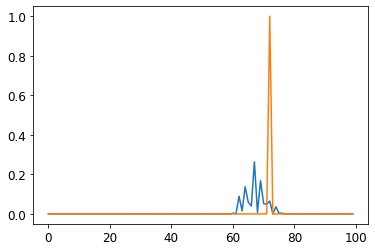

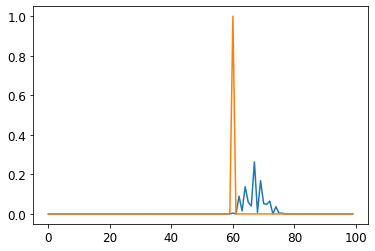

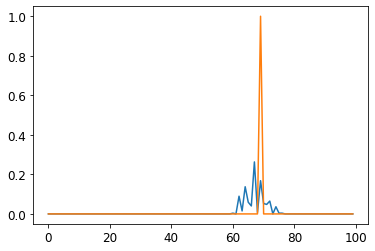

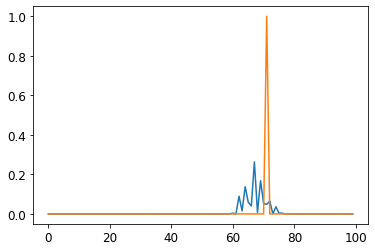

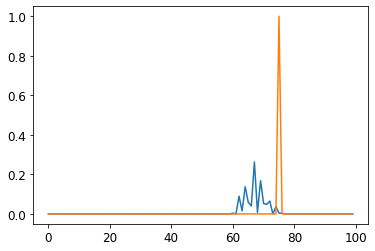

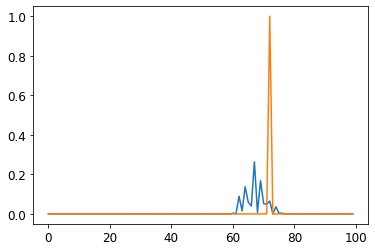

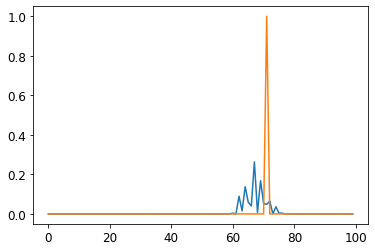

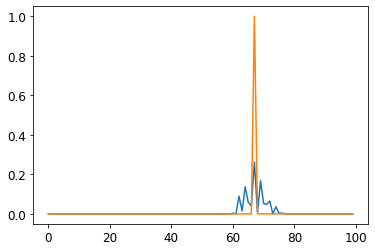

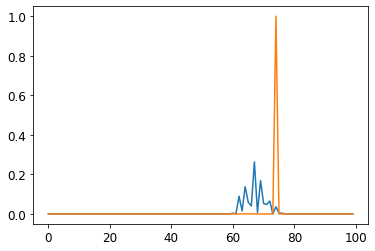

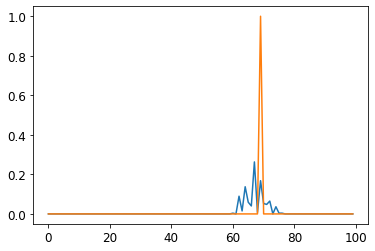

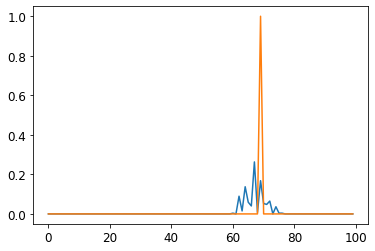

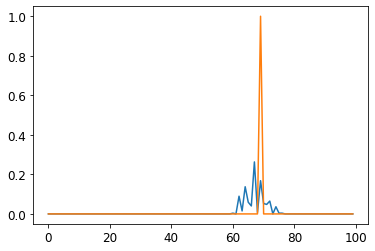

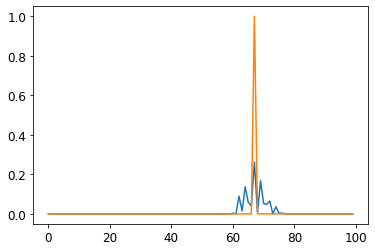

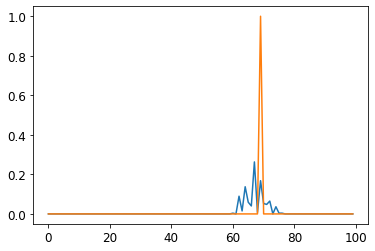

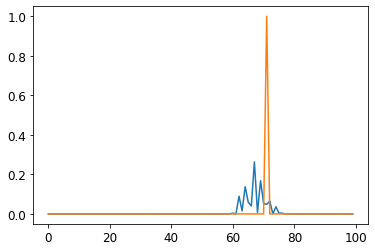

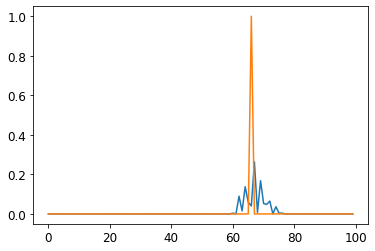

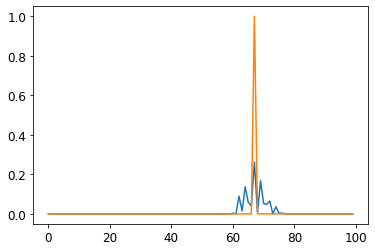

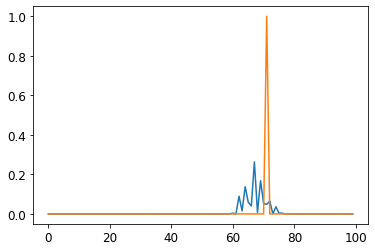

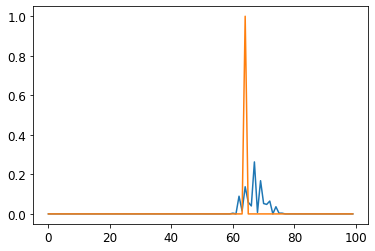

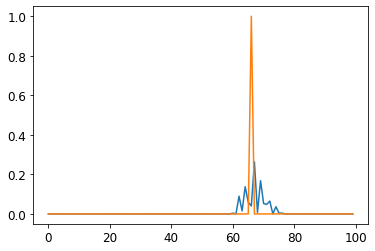

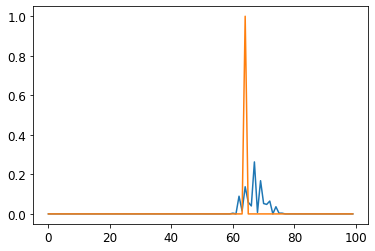

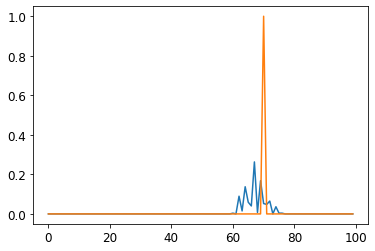

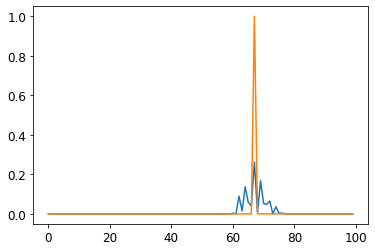

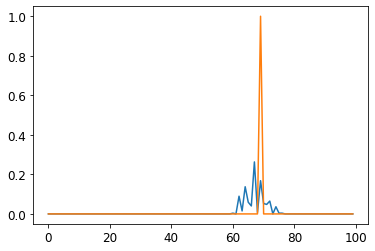

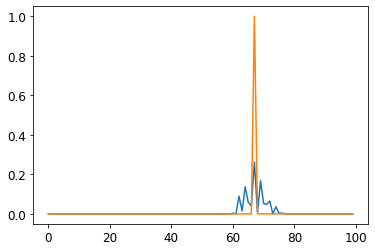

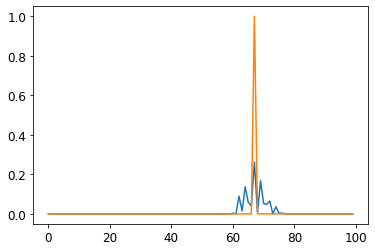

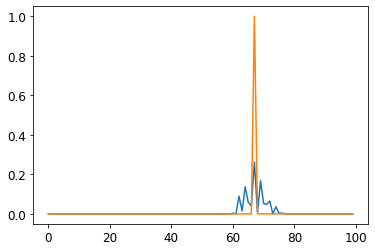

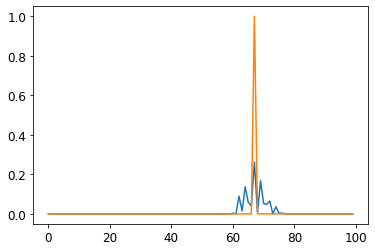

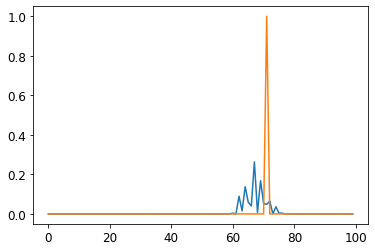

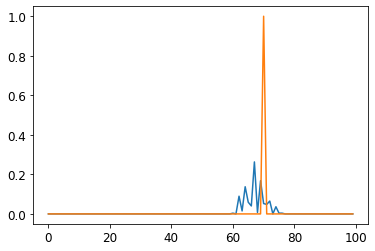

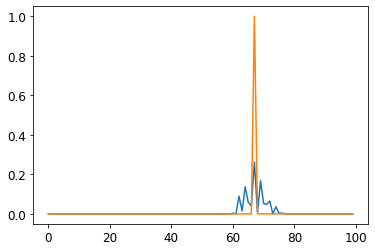

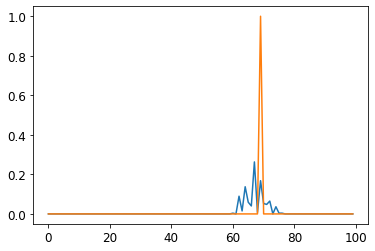

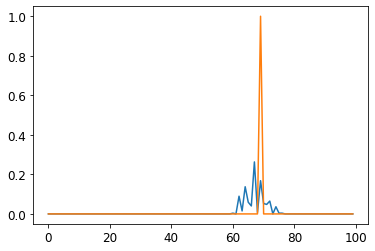

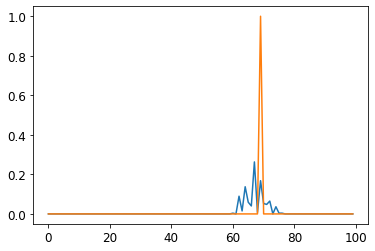

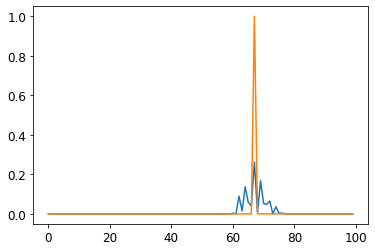

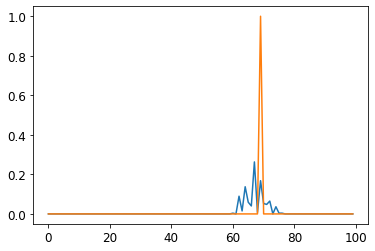

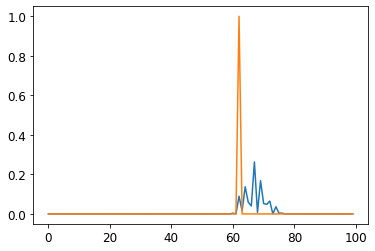

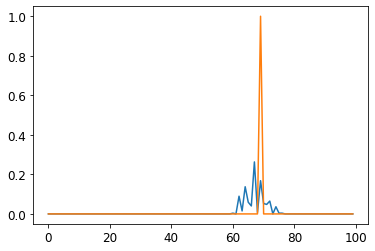

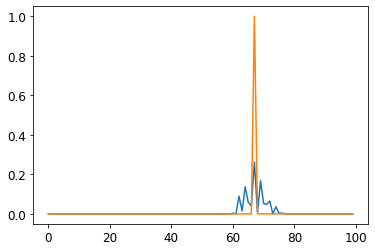

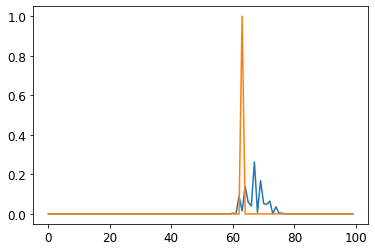

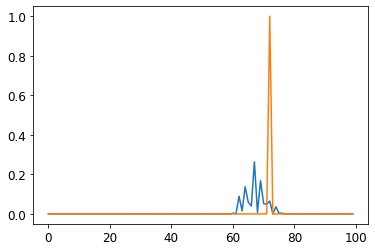

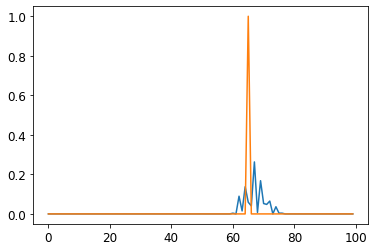

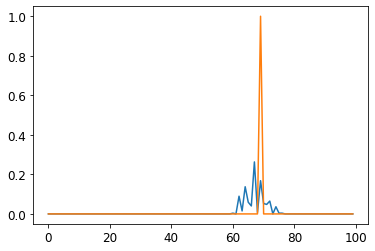

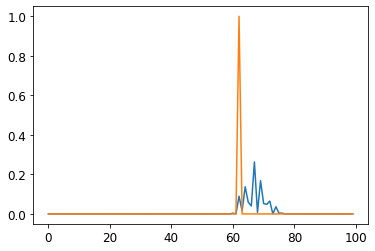

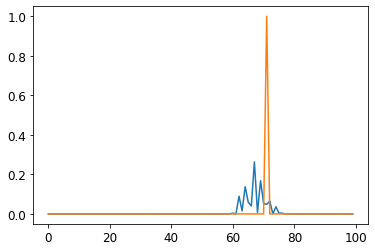

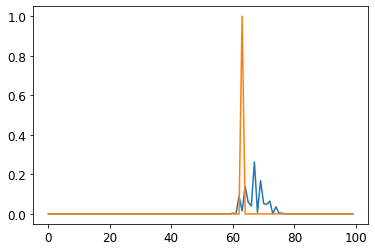

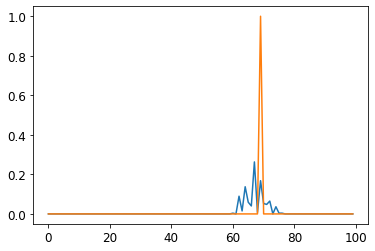

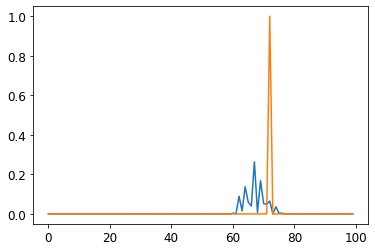

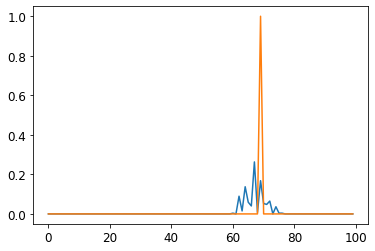

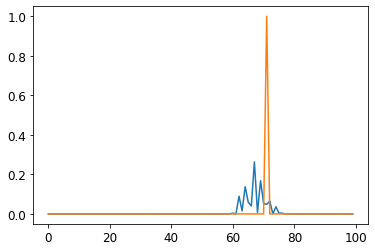

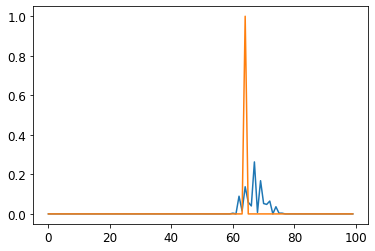

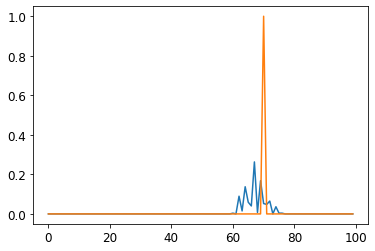

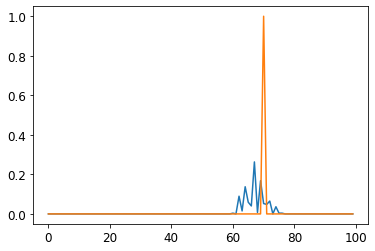

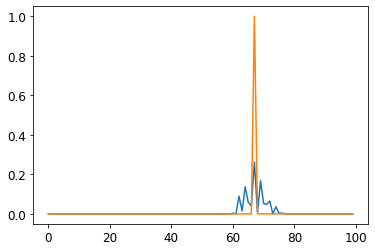

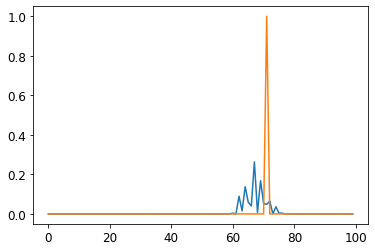

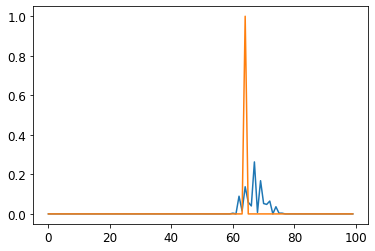

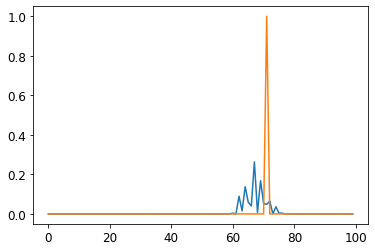

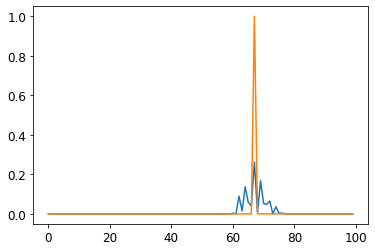

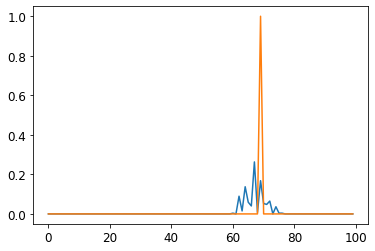

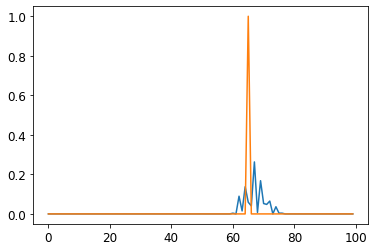

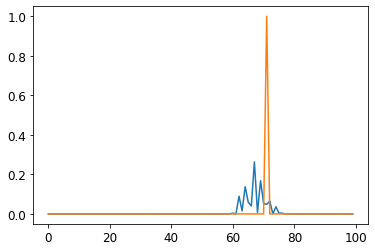

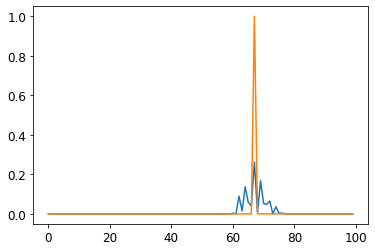

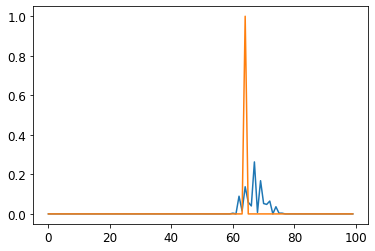

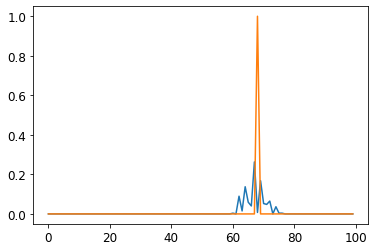

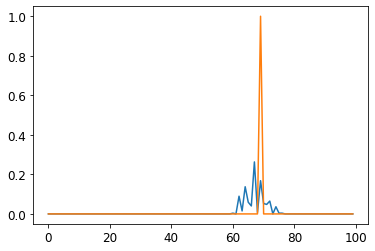

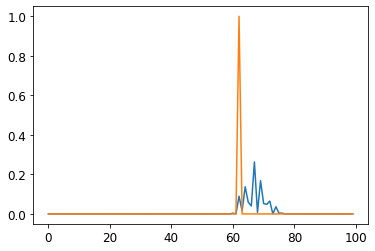

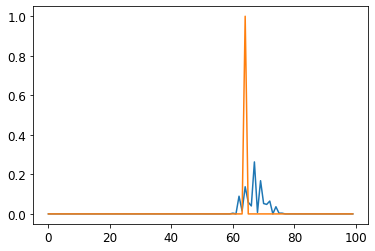

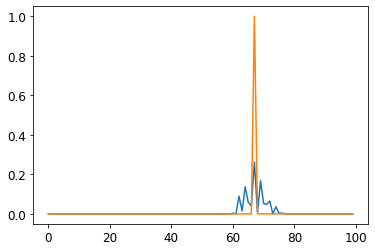

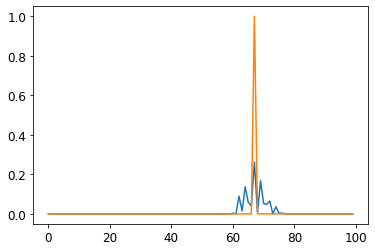

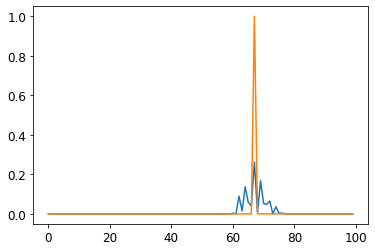

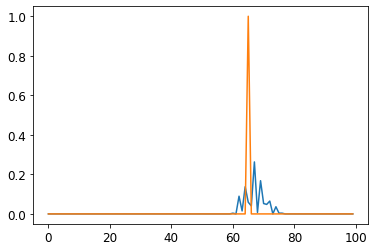

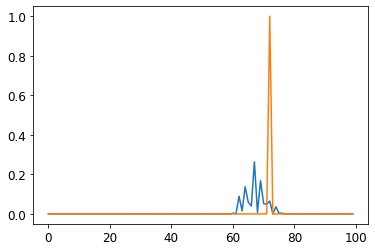

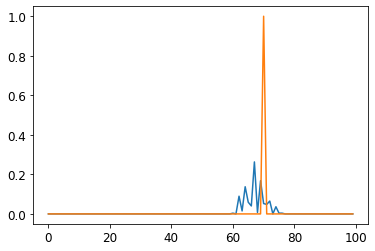

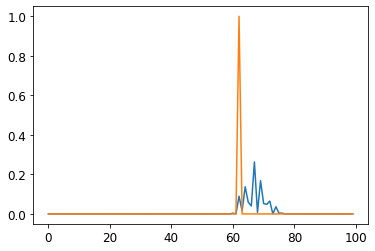

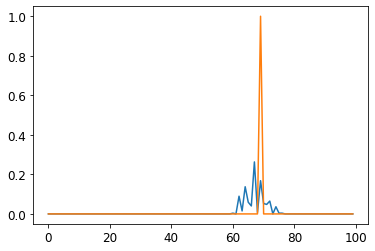

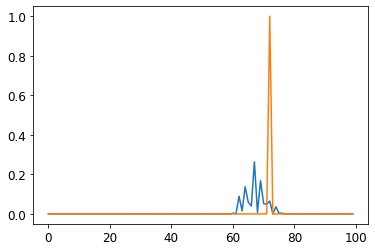

In [0]:
for example_index in range(len(predictions)):
  plt.plot(range(100), predictions[example_index])
  plt.plot(range(100), validation_bass_last_notes_categorical[example_index])
  plt.show()

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Adam(lr=0.005)

input = keras.layers.Input(shape=(576, 4))
masked_input = keras.layers.Masking(mask_value=0., input_shape=(576, 4))(input)
rnn1 = keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 4])(masked_input)
rnn2 = keras.layers.SimpleRNN(20)(rnn1)
note1 = keras.layers.Dense(100, activation="softmax")(rnn2)
note2 = keras.layers.Dense(100, activation="softmax")(rnn2)
note3 = keras.layers.Dense(100, activation="softmax")(rnn2)
note4 = keras.layers.Dense(100, activation="softmax")(rnn2)

model = keras.models.Model(inputs=input, outputs=[note1, note2, note3, note4])
model.compile(loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"], optimizer=optimizer)

history = model.fit(training_minus_last_notes_padded, 
                    y=[training_last_note1s_categorical, training_last_note2s_categorical, training_last_note3s_categorical, training_last_note4s_categorical], 
                    epochs=35,
                    validation_data=(validation_minus_last_notes_padded, [validation_last_note1s_categorical, validation_last_note2s_categorical, validation_last_note3s_categorical, validation_last_note4s_categorical]))

Train on 229 samples, validate on 76 samples
Epoch 1/35
229/229 [==============================] - 10s 45ms/sample - loss: 17.3932 - dense_14_loss: 4.4736 - dense_15_loss: 4.0929 - dense_16_loss: 4.2405 - dense_17_loss: 4.3716 - val_loss: 15.4362 - val_dense_14_loss: 3.9731 - val_dense_15_loss: 3.5772 - val_dense_16_loss: 3.8761 - val_dense_17_loss: 3.9489
Epoch 2/35
229/229 [==============================] - 8s 37ms/sample - loss: 13.8505 - dense_14_loss: 3.4591 - dense_15_loss: 3.0658 - dense_16_loss: 3.3620 - dense_17_loss: 3.6898 - val_loss: 12.2723 - val_dense_14_loss: 2.9871 - val_dense_15_loss: 2.7537 - val_dense_16_loss: 3.1174 - val_dense_17_loss: 3.2705
Epoch 3/35
229/229 [==============================] - 8s 36ms/sample - loss: 11.1384 - dense_14_loss: 2.6927 - dense_15_loss: 2.4534 - dense_16_loss: 2.8214 - dense_17_loss: 3.0177 - val_loss: 10.7445 - val_dense_14_loss: 2.5246 - val_dense_15_loss: 2.4609 - val_dense_16_loss: 2.7475 - val_dense_17_loss: 2.8106
Epoch 4/35
229/

- OK, I can train a network with multiple outputs!

But the model is still just finding the average data distribution and not learning to predict the the output based on the input :-(

Now let's try predicting the output continuously (but just 1 step ahead at a time.)

In [0]:
def create_features_and_targets(chorales):

  chorales_minus_last_notes = []
  chorales_minus_first_notes = []
  for chorale in chorales:
    chorales_minus_last_notes.append(chorale[:-1])
    chorales_minus_first_notes.append(chorale[1:])

  note1_all_but_first = []
  note2_all_but_first = []
  note3_all_but_first = []
  note4_all_but_first = []
  for chorale in chorales_minus_first_notes:
    note1s = []
    note2s = []
    note3s = []
    note4s = []
    for chord in chorale:
      note1s.append([chord[0]])
      note2s.append([chord[1]])
      note3s.append([chord[2]])
      note4s.append([chord[3]])

    note1_all_but_first.append(note1s)
    note2_all_but_first.append(note2s)
    note3_all_but_first.append(note3s)
    note4_all_but_first.append(note4s)

  chorales_minus_last_notes_padded = tf.keras.preprocessing.sequence.pad_sequences(chorales_minus_last_notes, padding='post', maxlen=600)
  note1_all_but_first_padded = tf.keras.preprocessing.sequence.pad_sequences(note1_all_but_first, padding='post', maxlen=600)
  note2_all_but_first_padded = tf.keras.preprocessing.sequence.pad_sequences(note2_all_but_first, padding='post', maxlen=600)
  note3_all_but_first_padded = tf.keras.preprocessing.sequence.pad_sequences(note3_all_but_first, padding='post', maxlen=600)
  note4_all_but_first_padded = tf.keras.preprocessing.sequence.pad_sequences(note4_all_but_first, padding='post', maxlen=600)

  note1_all_but_first_catagorical = tf.keras.utils.to_categorical(note1_all_but_first_padded, num_classes=100)
  note2_all_but_first_catagorical = tf.keras.utils.to_categorical(note2_all_but_first_padded, num_classes=100)
  note3_all_but_first_catagorical = tf.keras.utils.to_categorical(note3_all_but_first_padded, num_classes=100)
  note4_all_but_first_catagorical = tf.keras.utils.to_categorical(note4_all_but_first_padded, num_classes=100)

  return chorales_minus_last_notes_padded, note1_all_but_first_catagorical, note2_all_but_first_catagorical, note3_all_but_first_catagorical, note4_all_but_first_catagorical


tr_chorales_minus_last_notes, tr_note1_all_but_first, tr_note2_all_but_first, tr_note3_all_but_first, tr_note4_all_but_first = create_features_and_targets(bach_training_chorales)
va_chorales_minus_last_notes, va_note1_all_but_first, va_note2_all_but_first, va_note3_all_but_first, va_note4_all_but_first = create_features_and_targets(bach_validation_chorales)
te_chorales_minus_last_notes, te_note1_all_but_first, te_note2_all_but_first, te_note3_all_but_first, te_note4_all_but_first = create_features_and_targets(bach_test_chorales)

print("tr_chorales_minus_last_notes.shape: ", tr_chorales_minus_last_notes.shape)
print("tr_note1_all_but_first.shape: ", tr_note1_all_but_first.shape)
print("tr_note2_all_but_first.shape: ", tr_note2_all_but_first.shape)
print("tr_note3_all_but_first.shape: ", tr_note3_all_but_first.shape)
print("tr_note4_all_but_first.shape: ", tr_note4_all_but_first.shape)

print("tr_note1_all_but_first[0][0]:\n", tr_note1_all_but_first[0][0])
print("va_note1_all_but_first[0][0]:\n", va_note1_all_but_first[0][0])


tr_chorales_minus_last_notes.shape:  (229, 600, 4)
tr_note1_all_but_first.shape:  (229, 600, 100)
tr_note2_all_but_first.shape:  (229, 600, 100)
tr_note3_all_but_first.shape:  (229, 600, 100)
tr_note4_all_but_first.shape:  (229, 600, 100)
tr_note1_all_but_first[0][0]:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
va_note1_all_but_first[0][0]:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Adam(lr=0.05)

input = keras.layers.Input(shape=(600, 4))
masked_input = keras.layers.Masking(mask_value=0., input_shape=(600, 4))(input)
rnn1 = keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 4])(masked_input)
rnn2 = keras.layers.SimpleRNN(20, return_sequences=True)(rnn1)
note1 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation="softmax"))(rnn2)
note2 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation="softmax"))(rnn2)
note3 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation="softmax"))(rnn2)
note4 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation="softmax"))(rnn2)

model = keras.models.Model(inputs=input, outputs=[note1, note2, note3, note4])
model.compile(loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"], optimizer=optimizer)

history = model.fit(tr_chorales_minus_last_notes, 
                    y=[tr_note1_all_but_first, tr_note2_all_but_first, tr_note3_all_but_first, tr_note4_all_but_first], 
                    epochs=15,
                    validation_data=(va_chorales_minus_last_notes, [va_note1_all_but_first, va_note2_all_but_first, va_note3_all_but_first, va_note4_all_but_first]))

Train on 229 samples, validate on 76 samples
Epoch 1/15
229/229 [==============================] - 12s 53ms/sample - loss: 5.4949 - time_distributed_4_loss: 1.3687 - time_distributed_5_loss: 1.3660 - time_distributed_6_loss: 1.3295 - time_distributed_7_loss: 1.4583 - val_loss: 4.3324 - val_time_distributed_4_loss: 1.0477 - val_time_distributed_5_loss: 1.0270 - val_time_distributed_6_loss: 1.0158 - val_time_distributed_7_loss: 1.1868
Epoch 2/15
229/229 [==============================] - 9s 41ms/sample - loss: 4.2545 - time_distributed_4_loss: 1.0327 - time_distributed_5_loss: 0.9998 - time_distributed_6_loss: 1.0045 - time_distributed_7_loss: 1.1476 - val_loss: 4.2285 - val_time_distributed_4_loss: 1.0372 - val_time_distributed_5_loss: 0.9957 - val_time_distributed_6_loss: 1.0127 - val_time_distributed_7_loss: 1.1462
Epoch 3/15
229/229 [==============================] - 9s 41ms/sample - loss: 4.2117 - time_distributed_4_loss: 1.0415 - time_distributed_5_loss: 1.0042 - time_distributed_6

In [0]:
predictions = model.predict(va_chorales_minus_last_notes)
print("predictions[0].shape: ", predictions[0].shape)
print("predictions[1].shape: ", predictions[1].shape)
print("Validation Predictions[note1=0][chorale=0][chord=0]:\n ", predictions[0][0][0])

predictions[0].shape:  (76, 600, 100)
predictions[1].shape:  (76, 600, 100)
Validation Predictions[note1=0][chorale=0][chord=0]:
  [1.52901921e-04 6.80839776e-07 2.29863943e-07 1.32349987e-06
 2.03610881e-07 3.85226571e-07 4.33413192e-07 1.04673416e-06
 7.99658721e-07 5.73416401e-07 5.77705976e-07 3.34533638e-07
 4.20966018e-07 4.93555490e-07 7.94749610e-07 3.03947814e-07
 1.21169830e-06 7.38789311e-07 3.21660480e-07 6.65955326e-07
 4.81633322e-07 3.09452957e-07 7.48144885e-07 6.51388291e-07
 1.06706250e-06 4.28094239e-07 9.61589308e-07 2.89035825e-07
 3.70526379e-07 8.88726220e-07 1.05624645e-06 7.37166488e-07
 5.67863367e-07 3.77612082e-07 3.78692164e-07 4.76195169e-07
 3.01347285e-07 3.12650741e-07 4.90027674e-07 3.42259568e-07
 5.78575452e-07 3.35321630e-07 6.56278758e-07 5.17036540e-07
 4.20162991e-07 9.81778953e-07 4.90831610e-07 3.76585348e-07
 3.96152871e-07 3.15377065e-07 6.72263639e-07 8.67470135e-07
 1.09659970e-06 4.43915610e-07 8.58752458e-07 8.92344133e-07
 5.83697499e-07

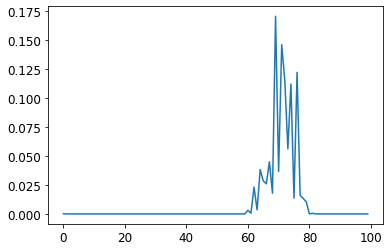

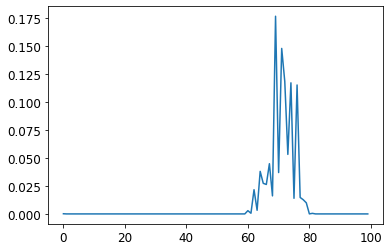

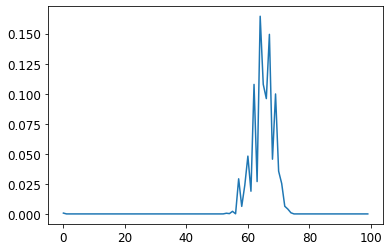

In [0]:
plt.plot(range(100), predictions[0][0][0])
plt.show()

plt.plot(range(100), predictions[0][0][20])
plt.show()

plt.plot(range(100), predictions[1][0][0])
plt.show()

# for example_index in range(len(predictions)):
#   plt.plot(range(100), predictions[example_index])
#   plt.plot(range(100), validation_bass_last_notes_categorical[example_index])
#   plt.show()

Tomorrow


- Model to continuously predict 1 time step in the future
- Model to continuously predict 10 time steps into the future

and then

- categorical model instead of regression model

In [0]:
print(model.loss_weights)

None


# Some sanity checking to make sure my data looks like the example in Ch. 15

In [0]:
rnn_weights

NameError: ignored

In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [0]:
print("X_train.shape: ", X_train.shape)
print("Xtrain:\n", X_train)
print("\n")
print("y_train.shape: ", y_train.shape)
print("Ytrain:\n", y_train)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [0]:
model.evaluate(X_valid, y_valid)

In [0]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()